In [1]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import random

In [2]:
execfile('ML_Challenge_data_preprocessing.py')

('Generated X with shape ', (347698, 1000))
('Generated y with shape ', (347698,))


In [3]:
X2 = []
y2 = []
for i, x in enumerate(X):
    if 'N' not in X[i,:]:
        X2.append(x)
        y2.append(y[i])
        
X2 = np.array(X2)
y2 = np.array(y2)
print X2.shape
print y2.shape

(347683, 1000)
(347683,)


In [4]:
# split into promotors and enhancers
promoter_idcs = (y2 == 0).nonzero()[0]
num_promoters = len(promoter_idcs)
enhancer_idcs = (y2 == 1).nonzero()[0]
num_enhancers = len(enhancer_idcs)
assert(num_promoters + num_enhancers == X2.shape[0])
promoter_X = X2[promoter_idcs,]
enhancer_X = X2[enhancer_idcs,]
print promoter_X.shape
print enhancer_X.shape

(274284, 1000)
(73399, 1000)


In [8]:
execfile('needleman_wunsch.py')

def compute_scores(num_pairs, X1, X2):
    scores = []
    for i in range(num_pairs):
        if i % 10 == 0: print 'Evaluating pair ' + str(i)
        random_idx1 = int(random.random()*X1.shape[0])
        random_idx2 = int(random.random()*X2.shape[0])
        # although this doesn't matter if X1 != X2
        assert(random_idx1 != random_idx2)
        seq1 = X1[random_idx1]
        seq2 = X2[random_idx2]
        score = needlman_wunsch(seq1, seq2)
        scores.append(score)
    return scores

In [9]:
num_pairs = 100
both_label0_seq_scores = compute_scores(num_pairs, promoter_X, promoter_X)
print both_label0_seq_scores[0:10]

Evaluating pair 0
Evaluating pair 10
Evaluating pair 20
Evaluating pair 30
Evaluating pair 40
Evaluating pair 50
Evaluating pair 60
Evaluating pair 70
Evaluating pair 80
Evaluating pair 90
[140.0, 5.0, 34.0, 66.0, 53.0, 40.0, 98.0, 75.0, 82.0, 97.0]


In [10]:
both_label1_seq_scores = compute_scores(num_pairs, enhancer_X, enhancer_X)
print both_label1_seq_scores[0:10]

Evaluating pair 0
Evaluating pair 10
Evaluating pair 20
Evaluating pair 30
Evaluating pair 40
Evaluating pair 50
Evaluating pair 60
Evaluating pair 70
Evaluating pair 80
Evaluating pair 90
[70.0, 23.0, 27.0, 51.0, 65.0, 86.0, 187.0, 46.0, 86.0, 25.0]


In [11]:
diff_label_seq_scores = compute_scores(num_pairs, enhancer_X, promoter_X)
print diff_label_seq_scores[0:10]

Evaluating pair 0
Evaluating pair 10
Evaluating pair 20
Evaluating pair 30
Evaluating pair 40
Evaluating pair 50
Evaluating pair 60
Evaluating pair 70
Evaluating pair 80
Evaluating pair 90
[62.0, 19.0, 10.0, 33.0, 25.0, 17.0, 14.0, -4.0, -48.0, -92.0]


Both sequences promoters


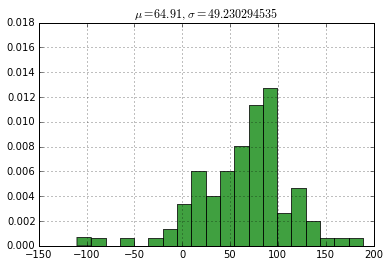

Both sequences enhancers


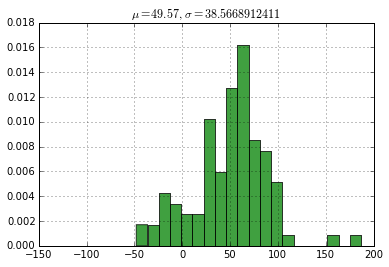

One promoter and one enhancer


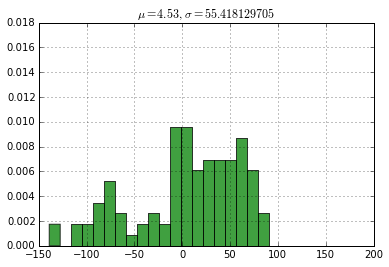

In [14]:
%matplotlib inline

def plot_lcs_lengths(seq_lengths):
    n, bins, patches = plt.hist(seq_lengths, 20, normed=1, facecolor='green', alpha=0.75)
    mu = np.mean(seq_lengths)
    sigma = np.std(seq_lengths)
    plt.title(r'$\mu=' + str(mu) + ',\ \sigma=' + str(sigma) + '$')
    # Note: there is a value lower, ths has cut some extremes
    plt.axis([-150,200,0,0.018])
    plt.grid(True)
    plt.show()

print 'Both sequences promoters'
plot_lcs_lengths(both_label0_seq_scores)
print 'Both sequences enhancers'
plot_lcs_lengths(both_label1_seq_scores)
print 'One promoter and one enhancer'
plot_lcs_lengths(diff_label_seq_scores)

In [15]:
import numpy as np

# TODO: add unit tests and put in file to share
def classify(sequence, num_comparisons,
             num_voters = 3.0,
             stat = 'majority_vote',
             alignment_algorithm = 'needlman_wunsch'):
    random_promoter_indcs = np.random.choice(len(promoter_X), num_comparisons)
    random_enhancer_indcs = np.random.choice(len(enhancer_X), num_comparisons)
    enhancer_scores = []
    promoter_scores = []
    for i in range(num_comparisons):
        enhancer = enhancer_X[random_enhancer_indcs[i],:]
        score_enh = eval(alignment_algorithm + '(enhancer, sequence)')
        enhancer_scores.append(score_enh)
        promoter = promoter_X[random_promoter_indcs[i],:]   
        score_prom = eval(alignment_algorithm + '(promoter, sequence)')
        promoter_scores.append(score_prom)
    promoter_scores.sort()
    enhancer_scores.sort()    
    votes_promoter = 0.0
    for i in range(int(num_voters)):
        if promoter_scores[i] > enhancer_scores[i]: votes_promoter += 1
    return 0 if round(votes_promoter/num_voters) == 1.0 else 1

In [19]:
import time

# NOTE: we have to ensure we don't train using the same sequence, but this should be ok in cv setup
errors = 0
num_trials = 100
num_comparisons = 10

start = time.clock()
for itera in range(1,num_trials+1):
    random_idx = np.random.choice(len(X), 1)[0]
    sequence = X[random_idx,:]
    true_class = y[random_idx]
    predicted_class = classify(sequence, num_comparisons)
    if predicted_class != true_class: errors += 1
finish = time.clock()

print 'Final accuracy: ' + str(1-float(errors)/num_trials)
print 'Total time: {0} for {1} trials and {2} comparisons'.format(finish - start, num_trials, num_comparisons)

Final accuracy: 0.8
Total time: 2779.904497 for 100 trials and 10 comparisons
